## Loading the Data

### Observations

The `observations.csv` contains information from recorded sightings of different species throughout the national parks in the past 7 days. The columns included are:

- **scientific_name** - The scientific name of each species
- **park_name** - The name of the national park
- **observations** - The number of observations in the past 7 days

In [68]:
import pandas as pd

observations = pd.read_csv('observations.csv')
observations.head(5)

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


### Species

The `species_info.csv` contains information on the different species in the National Parks. The columns in the data set include:
- **category** - The category of taxonomy for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The species conservation status

In [69]:
species = pd.read_csv('species_info.csv')
species.head(5)

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


## Explore the Data

### Explore `species`

#### Column `scientific_name`

Finding the number of individual species in the data. Using the `scientific_name' column, we get 5,541 unique species.

In [70]:
species.scientific_name.nunique()

5541

#### Column `category`

Finding the number of unique values in `category` that are represented in the `species` table, including animals and plants. 

There are 7 including animals and plants.

In [71]:
print(species.category.nunique())
species.category.unique()

7


array(['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant',
       'Nonvascular Plant'], dtype=object)

Let's look at the count of `category` in the data.

In [72]:
species.groupby("category").size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

#### Column `conservation_status`

There are 5,633 nan-values, which means that these are species that are not of concern. On the other hand, there are 161 species of concern, 16 endangered species, 10 threatened species, and 4 species in recovery.

In [73]:
print(f"NaN values:{species.conservation_status.isna().sum()}")
species.groupby("conservation_status").size()

NaN values:5633


conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64

### Explore `observations`

#### Column `park_name`

The number of parks that are in the dataset and there are only 4 national parks.

In [74]:
print(f"Parks:{observations.park_name.nunique()}")
observations.park_name.unique()

Parks:4


array(['Great Smoky Mountains National Park', 'Yosemite National Park',
       'Bryce National Park', 'Yellowstone National Park'], dtype=object)

#### Column `observations`

Total number of observations recorded in the parks - 3,314,739 observations.

In [75]:
print(f"Number of observations:{observations.observations.sum()}")

Number of observations:3314739


## Data analysis

First task will be to clean and explore the `conservation_status` column in `species`. 

We need to convert the `NaN` values to `No Intervention` in the conservation_status column

In [76]:
species.fillna('No Intervention', inplace=True)
species.groupby("conservation_status").size()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

The various categories that are nested in the conservation_status column should be checked, with the exception of those that do not require intervention.

In [77]:
# Calculate the count of species based on conservation status and category
conservation_category = species[species.conservation_status != "No Intervention"]\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

conservation_category

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


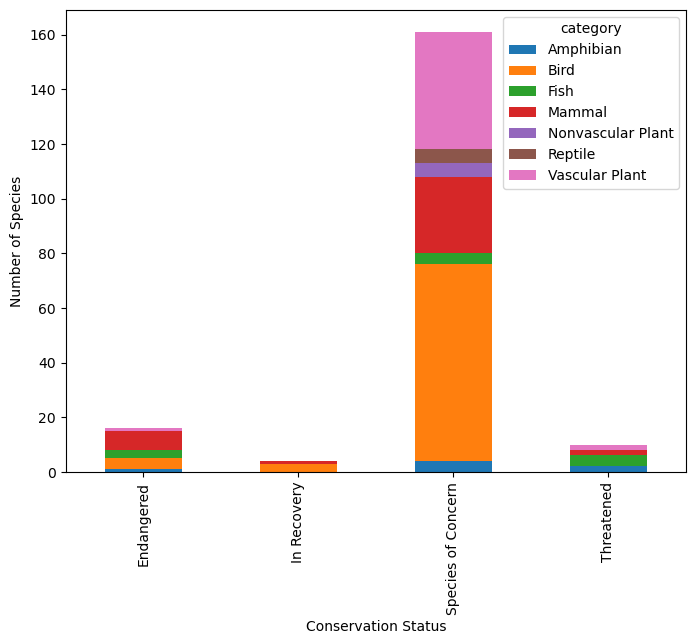

In [78]:
import matplotlib.pyplot as plt

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
conservation_category.plot(kind='bar', stacked=True, ax=ax)

# Customize the x-axis and y-axis labels
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species")

# Show the plot
plt.show()

The next question is whether certain species may be in danger of extinction? 

In [79]:
species['protected'] = species.conservation_status != 'No Intervention'

In [80]:
category_counts = species.groupby(['category', 'protected'])\
                        .scientific_name.nunique()\
                        .reset_index()\
                        .pivot(columns='protected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']

category_counts

,category,not_protected,protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


Calculating the rate of protection that each `category` exhibits in the data.

In [81]:
category_counts['percentage_protected'] = category_counts.protected / \
                                      (category_counts.protected + category_counts.not_protected) * 100

category_counts

,category,not_protected,protected,percentage_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


### Statistical Significance

Running some chi-squared tests to see if different species have statistically significant differences in conservation status rates.

The contingency table should look like this:

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Bird|?|?|

The first test will be called `contingency_1` and will need to be filled with the correct numbers for mammals and birds.

The standard p-value to test statistical significance is 0.05. For the value retrieved from this test, the value of 0.69 is larger than 0.05. In the case of mammals and birds there doesn't seem to be any significant relationship between them i.e. the variables independent.

In [83]:
from scipy.stats import chi2_contingency

contingency_1 = [[30, 146],
              [75, 413]]
chi2_contingency(contingency1)

(0.1617014831654557,
 0.6875948096661336,
 1,
 array([[ 27.8313253, 148.1686747],
        [ 77.1686747, 410.8313253]]))

Next, the difference between `Reptile` and `Mammal` is checked.

This time the p-value is 0.039 which is below the standard threshold of 0.05 which can be take that the difference between reptile and mammal is statistically significant. Mammals are shown to have a statistically significant higher rate of needed protection compared with Reptiles. 

In [85]:
contingency_2 = [[30, 146],
               [5, 73]]
chi2_contingency(contingency2)

(4.289183096203645,
 0.03835559022969898,
 1,
 array([[ 24.2519685, 151.7480315],
        [ 10.7480315,  67.2519685]]))

#### Species in Parks

The next set of analyses will come from data from conservation organizations that have recorded sightings of various species in several national parks.

The first step is to look at the the common names from `species` to get an idea of the most prevalent animals in the dataset. The data will be need to be split up into individual names. 

In [90]:
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species[species.category == "Mammal"]\
    .common_names\
    .apply(remove_punctuations)\
    .str.split().tolist()

common_Names[:5]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk']]

Cleaning up duplicate words in each row since they should no be counted more than once per species.

In [91]:
cleanRows = []

for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
cleanRows[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

Next the words need to be collapsed into one list for easier use.

In [92]:
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
res[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

The data is ready to be able to count the number of occurrences of each word. From this analysis, it seems that `Bat` occurred 23 times while `Shrew` came up 18 times.

In [93]:
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count']).sort_values("Count", ascending = False).head(10)

,Word,Count
107,Bat,23
121,Shrew,18
146,Myotis,17
127,Mouse,16
100,Chipmunk,13
181,Squirrel,12
90,American,12
4,Eastern,11
35,Vole,11
24,Mountain,10


The next task is to figure out which rows of `species` are referring to bats. A new column made up of boolean values will be created to check if `is_bat` is `True`.

In [96]:
species['is_bat'] = species.common_names.str.contains(r"\bBat\b", regex = True)

species.head(15)

,category,scientific_name,common_names,conservation_status,protected,is_bat
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False
5,Mammal,Odocoileus virginianus,White-Tailed Deer,No Intervention,False,False
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",No Intervention,False,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True,False
8,Mammal,Canis lupus,Gray Wolf,Endangered,True,False
9,Mammal,Canis rufus,Red Wolf,Endangered,True,False


This is a subset of the data in which `is_bat` is true, going back to look at the lines that matched. There appear to be multiple species of bats and a combination of protected and unprotected species.

In [97]:
species[species.is_bat]

,category,scientific_name,common_names,conservation_status,protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Intervention,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Intervention,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,No Intervention,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,No Intervention,False,True


Next the results of the bat species will be merged with `observations` to create a `DataFrame` with observations of bats across the four national parks.  

In [98]:
bat_observations = observations.merge(species[species.is_bat])
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Intervention,False,True
...,...,...,...,...,...,...,...,...
139,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
140,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
141,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


Let's see how many total bat observations(across all species) were made at each national park.  

In [99]:
bat_observations.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786


Now let's look at each park by protected bat encounters and unprotected bats. It appears that in every park, with the exception of Great Smoky Mountains National Park, there are more protected bats than unprotected bats.

In [101]:
obs_by_park = bat_observations.groupby(['park_name', 'protected']).observations.sum().reset_index()
obs_by_park

,park_name,protected,observations
0,Bryce National Park,False,1596
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1299
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4044
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2345
7,Yosemite National Park,True,2441


Below is the graph from the latest data manipulation. From this graph, you can see that Yellowstone and Bryce National Parks seem to be doing fine with their bat populations, as more protected bats are found there compared to non-protected species. Great Smoky Mountains National Park may need to step up its conservation efforts because there are more unprotected species found there.

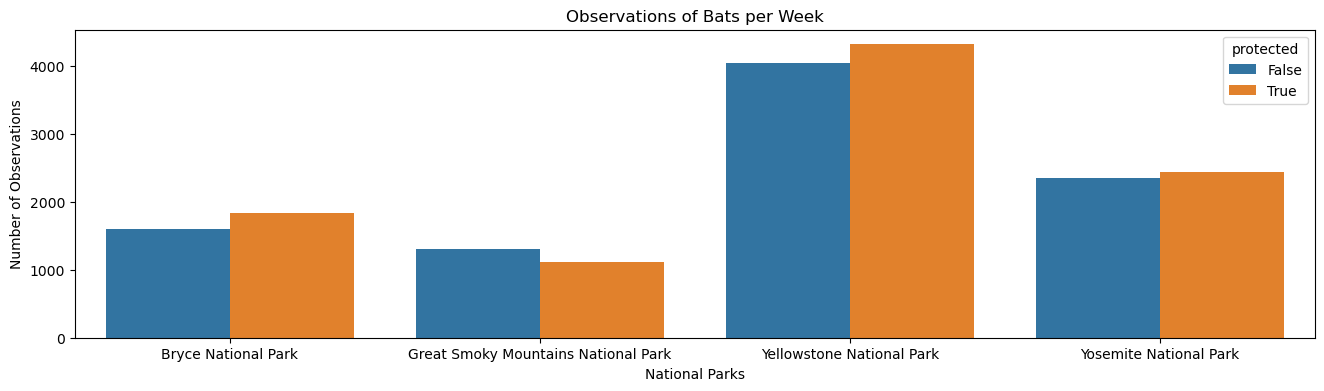

In [104]:
import seaborn as sns

# Create the bar plot
plt.figure(figsize=(16, 4))
sns.barplot(x=obs_by_park.park_name, y=obs_by_park.observations, hue=obs_by_park.protected)

# Customize the x-axis and y-axis labels, and the title
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats per Week')

# Show the plot
plt.show()

## Conclusions

This project also answered some of the questions posed at the outset:

- What is the distribution of conservation status for species?
 - The vast majority of species were not included in conservation status.(5,633 vs. 191)
- Are some species more likely to be threatened with extinction? 
 - Mammals and birds had the highest percentages of being protected.
- Are the differences between species and their conservation status significant?
 - While mammals and birds did not have a significant difference in conservation percentages, mammals and reptiles had statistically significant differences.
- Which animals are most common and what is their distribution across the parks?
 - The study showed that bats were the most frequently seen and most often seen in Yellowstone National Park.